In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/drive/MyDrive/Skin_CNN'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [6]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,basal cell carcinoma,376
1,seborrheic keratosis,77
2,vascular lesion,139
3,dermatofibroma,95
4,squamous cell carcinoma,181
5,pigmented benign keratosis,462
6,actinic keratosis,114
7,nevus,357
8,melanoma,438


Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


create a code to visualize one instance of all the nine classes present in the dataset

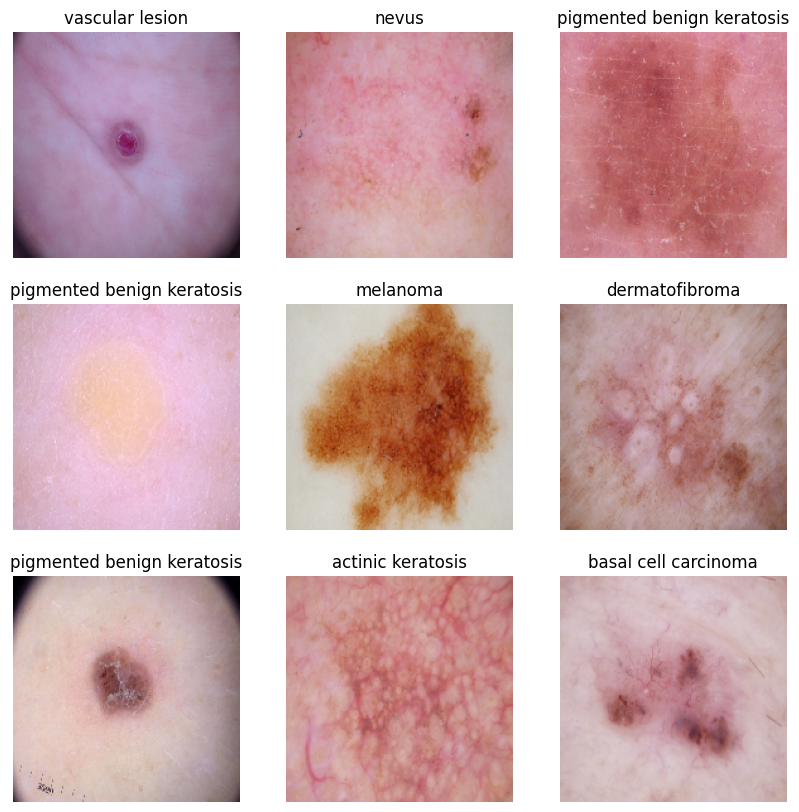

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create the model

Create a CNN model, which can accurately detect 9 classes present in the dataset

In [14]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [15]:
### Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrap  (None, 178, 178, 32)      896       
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 176, 176, 32)      9248      
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 88, 88, 32)        0         
 apper)                                                          
                                                                 
 module_wrapper_3 (ModuleWr  (None, 86, 86, 64)        18496     
 apper)                                                 

Compile the model

Choosing an appropirate optimiser and loss function for model training

In [16]:
### Selecting an appropirate optimiser and loss function

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrap  (None, 178, 178, 32)      896       
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 176, 176, 32)      9248      
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 88, 88, 32)        0         
 apper)                                                          
                                                                 
 module_wrapper_3 (ModuleWr  (None, 86, 86, 64)        18496     
 apper)                                                 

Train the model

In [18]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 328s 5s/step - loss: -82733.4609 - accuracy: 0.1719 - val_loss: -63740.5664 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 284s 5s/step - loss: -925349.4375 - accuracy: 0.1724 - val_loss: -832287.0000 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 293s 5s/step - loss: -3477163.5000 - accuracy: 0.1724 - val_loss: -3640672.0000 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 283s 5s/step - loss: -8493940.0000 - accuracy: 0.1724 - val_loss: -9837579.0000 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 289s 5s/step - loss: -16896074.0000 - accuracy: 0.1724 - val_loss: -18093596.0000 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 282s 5s/step - loss: -29382378.0000 - accuracy: 0.1724 - val_loss: -27685936.0000 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 283s 5s/step - loss:

Visualizing training results

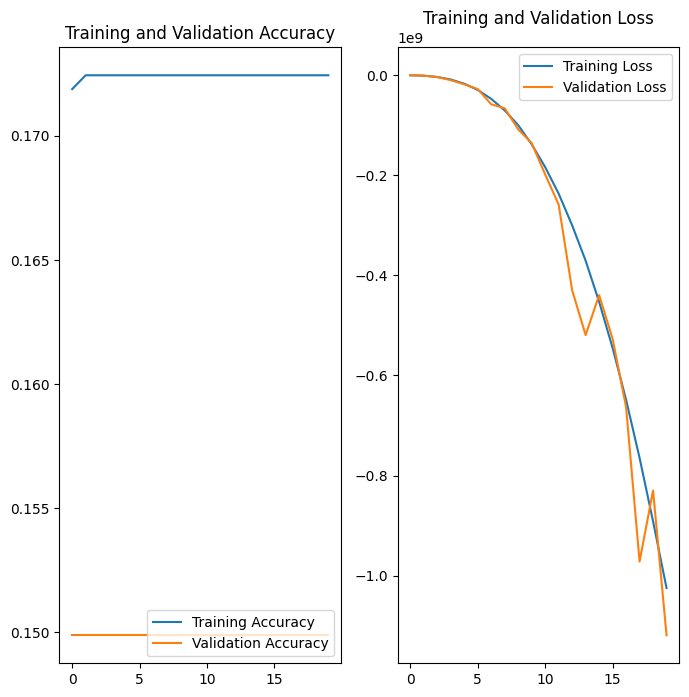

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model fitting Check:

In [20]:

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 17s 1s/step - loss: -1119150080.0000 - accuracy: 0.1499
Accuracy:  0.1724330335855484
Validation Accuracy:  0.14988814294338226
Loss:  -1085262720.0
Validation Loss -1119150080.0


Results indicate clear overfitting and I have to chose right data augumentation strategy

<Axes: xlabel='No. of Image', ylabel='Class'>

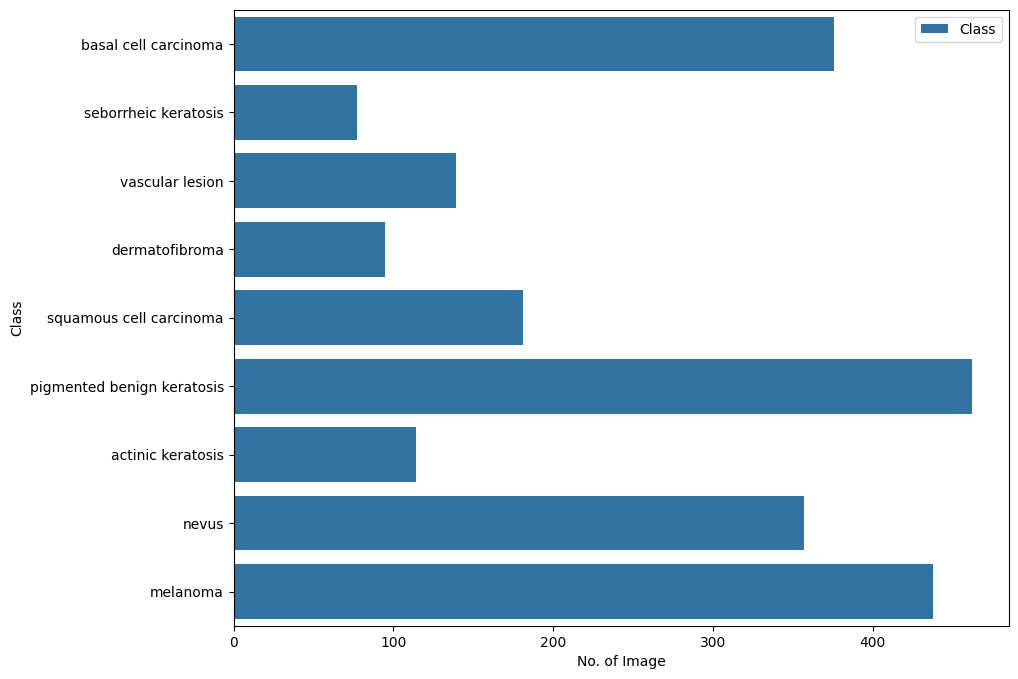

In [21]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

Questions:

Which class has the least number of samples? Actinic Keratosis

Which classes dominate the data in terms of the proportionate number of samples? pigmented benign keratosis & Melanoma

In [22]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal cell carcinoma','actinic keratosis','vascular lesion','dermatofibroma', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma']

train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)


Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


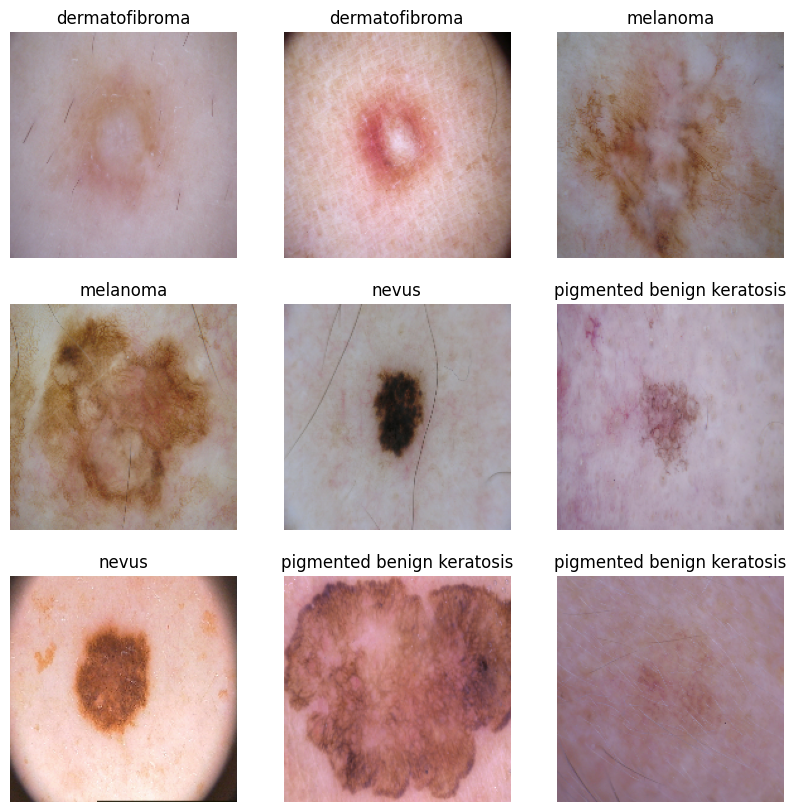

In [23]:
# visualize how augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Create the model, compile and train the model

In [24]:
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.build(input_shape=(None, 180, 180, 3))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_13 (ModuleW  (None, 180, 180, 32)      896       
 rapper)                                                         
                                                                 
 module_wrapper_14 (ModuleW  (None, 180, 180, 32)      9248      
 rapper)                                                         
                                                                 
 module_wrapper_15 (ModuleW  (None, 90, 90, 32)        0         
 rapper)                                                         
                                                                 
 module_wrapper_16 (ModuleW  (None, 90, 90, 32)        0         
 rapper)                                                         
                                                                 
 module_wrapper_17 (ModuleW  (None, 90, 90, 64)       

Compiling the model

In [25]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, weight_decay=None)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

In [26]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
35/35 [==============================] - 558s 16s/step - loss: 81.7817 - accuracy: 0.1733 - val_loss: 2.1655 - val_accuracy: 0.1525 - lr: 0.0010
Epoch 2/20
35/35 [==============================] - 508s 14s/step - loss: 1.9240 - accuracy: 0.2845 - val_loss: 2.2791 - val_accuracy: 0.2542 - lr: 0.0010
Epoch 3/20
35/35 [==============================] - 499s 14s/step - loss: 2.0180 - accuracy: 0.2483 - val_loss: 2.1842 - val_accuracy: 0.1864 - lr: 0.0010
Epoch 4/20
35/35 [==============================] - 497s 14s/step - loss: 1.8538 - accuracy: 0.3359 - val_loss: 2.0785 - val_accuracy: 0.2203 - lr: 0.0010
Epoch 5/20
35/35 [==============================] - ETA: 0s - loss: 1.7790 - accuracy: 0.3662 
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
35/35 [==============================] - 497s 14s/step - loss: 1.7790 - accuracy: 0.3662 - val_loss: 2.1704 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 6/20
35/35 [==============================] - 503s 14s/ste

Visualizing the results

<built-in method keys of dict object at 0x7f0e4cb2bc00> :


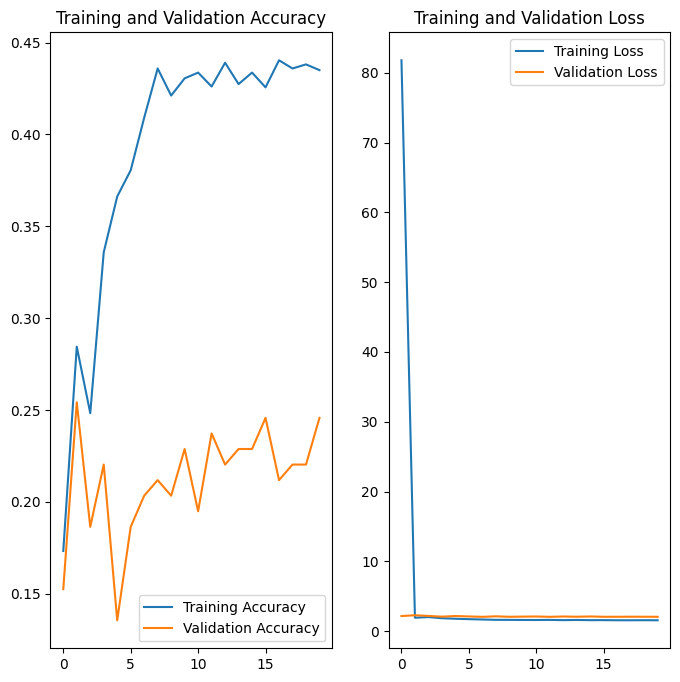

In [28]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

Rectify the class imbalance

In [30]:
!pip install Augmentor

In [31]:
path_to_training_dataset="/content/drive/MyDrive/Skin_CNN/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_CNN/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0E4D28BE20>: 100%|██████████| 500/500 [00:31<00:00, 15.79 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_CNN/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0E4D217760>: 100%|██████████| 500/500 [00:30<00:00, 16.29 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_CNN/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0E4D23BDF0>: 100%|██████████| 500/500 [00:25<00:00, 20.00 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_CNN/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0E4CBEA890>: 100%|██████████| 500/500 [01:55<00:00,  4.32 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_CNN/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F0E4CBEA290>: 100%|██████████| 500/500 [01:32<00:00,  5.43 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_CNN/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0E4D270310>: 100%|██████████| 500/500 [00:23<00:00, 21.31 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_CNN/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0E4D21C1C0>: 100%|██████████| 500/500 [00:50<00:00,  9.82 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_CNN/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0E4CB261D0>: 100%|██████████| 500/500 [00:22<00:00, 22.43 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_CNN/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0E4D21DA50>: 100%|██████████| 500/500 [00:25<00:00, 19.87 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Checking the total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


The distribution of augmented data after adding new images to the original training data.

In [33]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Skin_CNN/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029545.jpg_fc46b14c-b9b6-406e-b6dd-9bd70c575503.jpg',
 '/content/drive/MyDrive/Skin_CNN/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029602.jpg_feae236f-7e49-4d83-b54f-8869ed4415fd.jpg',
 '/content/drive/MyDrive/Skin_CNN/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025557.jpg_c59a387a-ca8d-4462-a9e0-330372394c1a.jpg',
 '/content/drive/MyDrive/Skin_CNN/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027601.jpg_a805f2f0-85a5-4f59-82ef-45b78cbe052f.jpg',
 '/content/drive/MyDrive/Skin_CNN/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031298.jpg_4453c7ea-60cb-43f3-8189-7dde069ad919.jpg',
 '/content/drive/MyDrive/Skin_CNN/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025718.jpg_03ed25ab-626e-4512-af70-8f6632c86f01.jpg',
 '/content/drive/MyDrive/Skin_CNN/Train/basal cell c

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [37]:
new_df['Label'].value_counts()

basal cell carcinoma          500
seborrheic keratosis          500
vascular lesion               500
dermatofibroma                500
squamous cell carcinoma       500
pigmented benign keratosis    500
actinic keratosis             500
nevus                         500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance.

Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

Create a training dataset

In [39]:
data_dir_train="/content/drive/MyDrive/Skin_CNN/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Create a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Model Creation (Including Normalization)

In [41]:

model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.build(input_shape=(None, 180, 180, 3))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_28 (ModuleW  (None, 180, 180, 32)      896       
 rapper)                                                         
                                                                 
 module_wrapper_29 (ModuleW  (None, 180, 180, 32)      9248      
 rapper)                                                         
                                                                 
 module_wrapper_30 (ModuleW  (None, 90, 90, 32)        0         
 rapper)                                                         
                                                                 
 batch_normalization_2 (Bat  (None, 90, 90, 32)        128       
 chNormalization)                                                
                                                                 
 module_wrapper_31 (ModuleW  (None, 90, 90, 32)       

Model Compilation (Selecting optimizer and loss function appropriately)

In [42]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, weight_decay=None, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

Model Training

In [2]:
epochs = 20

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Visualize the model results

In [2]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )